In [ ]:
from functools import partial
import jax
import jax.numpy as jnp
import jax.random as jr
import equinox as eqx
import diffrax as dfx
import optax
import numpy as np 
import matplotlib.pyplot as plt
from chainconsumer import Chain, ChainConsumer
import tensorflow_probability.substrates.jax.distributions as tfd

from configs import make_dirs
from configs.shear import shear
from data.shear import get_shear_experiment, simulator 
from sbiax.ndes import Ensemble
from sbiax.utils import make_df
from sbiax.ndes import CNF, Scaler
from sbiax.train import train_ensemble
from sbiax.compression.nn import fit_nn
from sbiax.inference.nle import nuts_sample

In [2]:
config = shear()

key = jr.key(config.seed)
key, model_key, nn_key, train_key, sample_key, data_key = jr.split(key, 6)

In [3]:
# Location of results / saving
results_dir  = (
    "/Users/Jed.Homer/phd/sbiax/results/" +  # Import this from a constants file
    f"{config.sbi_type}/" + 
    f"{config.exp_name}_nn/" + 
    f"{config.model.model_type}/" + 
    f"{config.seed}/"
)
make_dirs(results_dir)

RESULTS_DIR:
 /Users/Jed.Homer/phd/sbiax/results/nle/shear_nn/cnf/0/


In [4]:
(
    alpha,
    parameter_names,
    mu,
    covariance,
    precision,
    dmu,
    F,
    Finv, 
    lower,
    upper
) = get_shear_experiment()


In [5]:
key_prior, key_simulate = jr.split(data_key)

# Data-generating likelihood 
_simulator = partial(
    simulator, 
    alpha=alpha, 
    mu=mu, 
    derivatives=dmu,
    covariance=covariance
)

# Sample prior 
parameter_prior = tfd.Blockwise(
    [
        tfd.Uniform(low=lower[p], high=upper[p]) 
        for p in range(alpha.size)
    ]
)
Y = parameter_prior.sample((config.n_s,), seed=key_prior)

# Simulate training set
keys = jr.split(key_simulate, config.n_s)
D = jax.vmap(_simulator)(keys, Y)

In [6]:
net_key, net_train_key = jr.split(nn_key)

net = eqx.nn.MLP(
    D.shape[-1], 
    Y.shape[-1], 
    width_size=32, 
    depth=2, 
    activation=jax.nn.tanh,
    key=net_key
)

opt = optax.adamw(1e-3)

preprocess_fn = lambda x: (x - D.mean(axis=0)) / D.std(axis=0)

model, losses = fit_nn(
    net_train_key, 
    net, 
    preprocess_fn(D), 
    Y, 
    opt, 
    n_batch=512, 
    patience=1000
)

X = jax.vmap(model)(preprocess_fn(D))

Stopped at step=2148:   2%|▏         | 2148/100000 [00:09<07:20, 222.06it/s, train=2.687E-03, valid=6.101E-03]


In [7]:
# Build neural density estimators
model_keys = jr.split(model_key, 2)

scaler = Scaler(X, Y, use_scaling=config.model.use_scaling)

solver = getattr(dfx, config.model.solver)()

ndes = [
    CNF(
        event_dim=alpha.size, 
        context_dim=alpha.size, 
        width_size=config.model.width_size,
        depth=config.model.depth, 
        solver=solver,
        activation=config.model.activation,
        dt=config.model.dt, 
        t1=config.model.t1, 
        dropout_rate=config.model.dropout_rate,
        exact_log_prob=config.model.exact_log_prob,
        scaler=scaler,
        key=key
    )
    for key in model_keys
]

ensemble = Ensemble(ndes, sbi_type=config.sbi_type)

In [8]:
opt = getattr(optax, config.opt)(config.lr)

ensemble, stats = train_ensemble(
    train_key, 
    ensemble,
    train_mode=config.sbi_type,
    train_data=[X, Y], 
    opt=opt,
    n_batch=config.n_batch,
    patience=config.patience,
    n_epochs=config.n_epochs,
    results_dir=results_dir
)

NDE has n_params=51.


Training terminated early at epoch 1349; valid=-6.658E+00, train=-6.631E+00.:  13%|█▎        | 1348/10000 [02:12<14:11, 10.16epoch/s, train=-6.631E+00, valid=-6.658E+00, best_valid=-6.725E+00, stop=0000]


NDE has n_params=51.


Training terminated early at epoch 1225; valid=-6.422E+00, train=-6.505E+00.:  12%|█▏        | 1224/10000 [02:02<14:41,  9.96epoch/s, train=-6.505E+00, valid=-6.422E+00, best_valid=-6.465E+00, stop=0000]


Weights: [0.5670161 0.4329839]


In [9]:
# Get a noisy datavector with different alpha parameters
key_data, key_state, key_sample = jr.split(sample_key, 3)

# Generates datavector d ~ G[d|xi[pi], Sigma]
datavector = jr.multivariate_normal(key_data, mu, covariance)

# Linear summary
X_ = model(preprocess_fn(datavector))

# Initial state of MCMC walkers
state = jr.multivariate_normal(
    key_state, X_, Finv, (2 * config.n_walkers,)
)

ensemble = eqx.nn.inference_mode(ensemble)

log_prob_fn = ensemble.ensemble_log_prob_fn(X_, parameter_prior)

In [10]:
samples, samples_log_prob = nuts_sample(
    key_sample, log_prob_fn, prior=parameter_prior
)

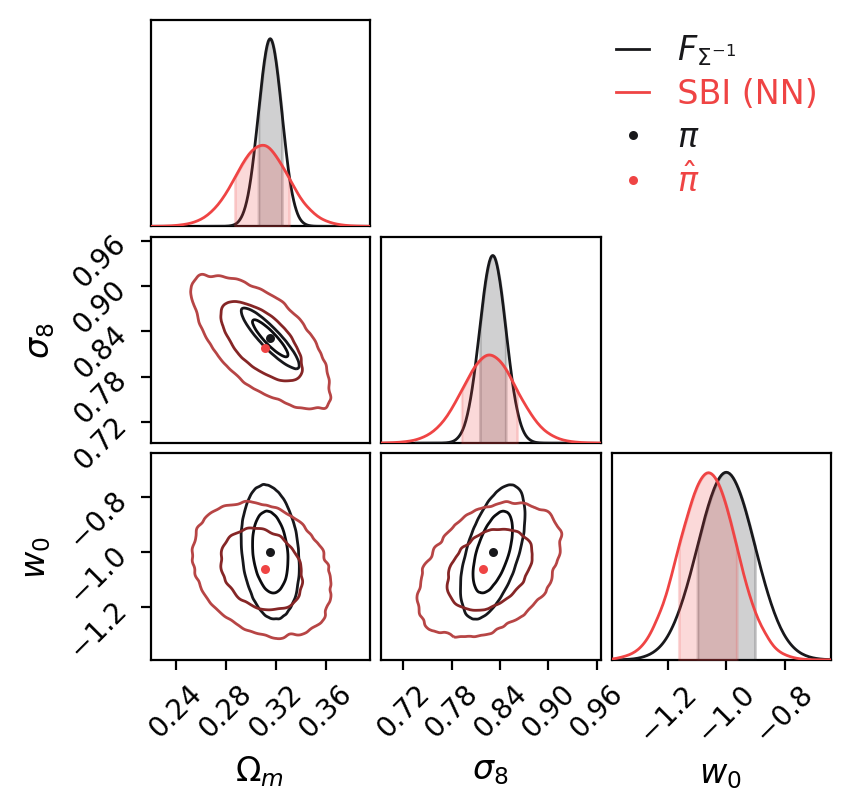

In [11]:
c = ChainConsumer()

c.add_chain(
    Chain.from_covariance(
        alpha,
        Finv,
        columns=parameter_names,
        name=r"$F_{\Sigma^{-1}}$",
        color="k",
        shade_alpha=0.
    )
)
c.add_chain(
    Chain(
        samples=make_df(samples, samples_log_prob, parameter_names), 
        name="SBI (NN)", 
        color="r", 
        shade_alpha=0.
    )
)
c.add_marker(
    location=dict(zip(parameter_names, np.asarray(alpha))), name=r"$\pi$", color="k"
)
c.add_marker(
    location=dict(zip(parameter_names, np.asarray(X_))), name=r"$\hat{\pi}$", color="r"
)

fig = c.plotter.plot()
fig.set_dpi(200)
fig.set_figheight(4.)
fig.set_figwidth(4.)
plt.show()